In [3]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import pickle
from sklearn.metrics import accuracy_score
import csv

In [4]:
# Define transformer model

import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.embedding = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.linear = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor = None, src_key_padding_mask: Tensor = None) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask, src_key_padding_mask=src_key_padding_mask)
        output = self.linear(output)
        return output

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Read data

In [9]:
# load unmodified genotype file
geno_data_full = pd.read_csv("Data/02_DFE_unimputed_genotypes.csv")
geno_data = geno_data_full.iloc[:, 4:].T
geno_ = geno_data.to_numpy()

line_names = pd.Series(geno_data_full.columns[4:])

line_names = line_names[np.sum(np.isnan(geno_), 1) != 169]
geno_ = geno_[np.sum(np.isnan(geno_), 1) != 169]

### Train models

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

ntokens = 2  # size of vocabulary
emsize = 200  # embedding dimension
d_hid = 32  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 4  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 1  # number of heads in ``nn.MultiheadAttention``
dropout = 0.1  # dropout probability
criterion = nn.CrossEntropyLoss()

In [96]:
n, L = geno.shape
geno_train = torch.tensor(geno_).long().to(device).T
nan_indices = (geno_train == -9223372036854775808) # get positions with Nan

model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 3000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    X_train = geno_train.clone()    
    mask_indices = ((torch.rand(X_train.shape) < 0.15).to(device)) # generate mask positions
    keep = X_train[mask_indices] != -9223372036854775808 # get positions used for backpropogation
    X_train[mask_indices] = torch.randint(2, (mask_indices.sum().item(), )).to(device) # Replace chosen positions with random 0/1

    # Forward pass
    logits = model(X_train, src_key_padding_mask=nan_indices.T)

    # Compute loss
    loss = criterion(logits[mask_indices][keep], geno_train[mask_indices][keep])

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch%100 == 0:
        # Print loss
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/3000, Loss: 0.8459080457687378
Epoch 101/3000, Loss: 0.6962880492210388
Epoch 201/3000, Loss: 0.6953751444816589
Epoch 301/3000, Loss: 0.6943534016609192
Epoch 401/3000, Loss: 0.6935312151908875
Epoch 501/3000, Loss: 0.6904879212379456
Epoch 601/3000, Loss: 0.6394132375717163
Epoch 701/3000, Loss: 0.6011759042739868
Epoch 801/3000, Loss: 0.563908040523529
Epoch 901/3000, Loss: 0.5435827970504761
Epoch 1001/3000, Loss: 0.5176733732223511
Epoch 1101/3000, Loss: 0.48295724391937256
Epoch 1201/3000, Loss: 0.434949666261673
Epoch 1301/3000, Loss: 0.41956937313079834
Epoch 1401/3000, Loss: 0.40220218896865845
Epoch 1501/3000, Loss: 0.3733724057674408
Epoch 1601/3000, Loss: 0.36602357029914856
Epoch 1701/3000, Loss: 0.3564711809158325
Epoch 1801/3000, Loss: 0.3401802182197571
Epoch 1901/3000, Loss: 0.32337939739227295
Epoch 2001/3000, Loss: 0.32222169637680054
Epoch 2101/3000, Loss: 0.324784517288208
Epoch 2201/3000, Loss: 0.3105078637599945
Epoch 2301/3000, Loss: 0.29378262162208557


### Prediction

In [105]:
model.eval()
logits = model(geno_train, src_key_padding_mask=nan_indices.T)
p_tensor = torch.nn.Softmax(dim=-1)(-logits).transpose(0, 1)[:, :, 0]

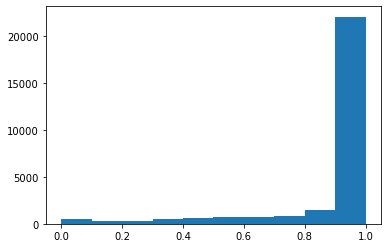

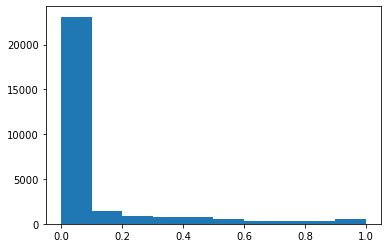

In [135]:
# Histograms of probabilities for 0 or 1 alleles

plt.hist(p_tensor[~nan_indices.T][geno_train.T[~nan_indices.T] == 1].cpu().detach().numpy())
plt.show()

plt.hist(p_tensor[~nan_indices.T][geno_train.T[~nan_indices.T] == 0].cpu().detach().numpy())
plt.show()

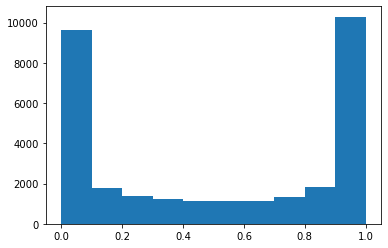

In [154]:
# This is the tensor for sampling genotypes
S_tensor = torch.clone(geno_train.T).float()

S_tensor[nan_indices.T] = p_tensor[nan_indices.T]

# Histogram of probability for nan positions
plt.hist(S_tensor[nan_indices.T].cpu().detach().numpy())
plt.show()

In [160]:
# Export predicted genotype probabilities
pd.DataFrame(S_tensor.detach().cpu().numpy(), index=line_names).to_csv("Data/Sampling_tensor.csv", header=None)